# new data aquisition

In [1]:
import datetime
import time

lights = 'OFF'
Oscillations = "OFF"
time_of_measurement = 17*60*60 # in [sec]


the_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M')

# input measurement time and basic description
description = "data from "+the_time+",  measuring - picomotor is static: \nOscillations: "+Oscillations+"\nLights are: "+lights

print("measerment will be ",time_of_measurement,"[sec] long - or ",time_of_measurement/(60*60),"[hours]")
print("\n"+description)

measerment will be  61200 [sec] long - or  17.0 [hours]

data from 20201013_1547,  measuring - picomotor is static: 
Oscillations: OFF
Lights are: OFF


In [2]:
# importing modules:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import os
import datetime
import timeit

import pyvisa as visa
import datetime
import time
from os.path import dirname as up

file_name = 'data_'+the_time

In [7]:
import os
#saving folder:
# 1 ) set directory.
dir_path = os.getcwd()
# 2) set the folder.
pickle_path = get_pickle_path(dir_path)
os.chdir(pickle_path)

In [8]:
# save in drive folder.
# print(os.getcwd())


## functons:

In [9]:
def chan_disp():
    #what chanels are showing?
    for i in range(4):
        chan = scope.query(":CHANnel{0}:DISPlay?".format(i+1))
        if int(chan) == 1:
#             print('channel {0}: on'.format(i+1))
            scope.write(":CHANnel{0}:PROBe 1".format(i+1))
            probe = scope.query(":CHANnel{0}:PROBe?".format(i+1))
            print('channel {0}: on ,'.format(i+1),"ch{0} probe:".format(i+1),float(probe))
        else:
            print('channel {0}: off'.format(i+1))
            
def the_data(chanl):
    scope.write(":STOP")
    scope.write(":WAV:SOUR CHAN{0}".format(chanl))
    scope.write(":WAV:MODE RAW")
    # scope.write(":WAV:FORM BYTE")
    scope.write(":WAV:FORM ASCII")
    # scope.write(":WAV:STAR 1")
    # scope.write(":WAV:STOP 15625")
    # x1 = scope.query(":WAV:DATA?")
    asci_pack = 15625
    steps = np.floor(memory_depth/asci_pack)
    steps = int(steps)
    # print(memory_depth)
    chan_data = []
    for i in range(steps):
        start_num = 1+asci_pack*i
        stop_num = asci_pack*(1+i)
        scope.write(":WAV:STAR {0}".format(start_num))
        scope.write(":WAV:STOP {0}".format(stop_num))
        #another_x = scope.query(":WAV:DATA?")
        another_x_list = ([np.float64(x.strip()) for x in scope.query(":WAV:DATA?").split(',')[1:]])
        chan_data = chan_data +another_x_list
    return chan_data  
def get_data_avg(chanl):
    x_vec = get_data(chanl)
    x_vec_mean = np.mean(x_vec)
    return x_vec_mean

def time_axis(samples):  #samples = chan_data
    timebase_scale = float(scope.query(":TIMebase:MAIN:SCALe?"))
    timebase_offset = float(scope.query(":TIMebase:MAIN:OFFSet?"))
    time_axis = [
            float(i * timebase_scale / 10.0 + timebase_offset)
            for i in range(-len(samples) // 2, len(samples) // 2)
        ]
    time_axis =([t -time_axis[0] for t in time_axis ]) 
    time_axis =([t*10/(7460753.6/(5)) for t in time_axis ])
    return time_axis

def get_data(chanl):
    print(scope.write(":WAV:SOUR CHAN{0}".format(chanl)))
    # scope.write(":WAV:STAR 1")
    # scope.write(":WAV:STOP 15625")
    # x1 = scope.query(":WAV:DATA?")
    asci_pack = 15625
    steps = np.floor(memory_depth/asci_pack)
    steps = int(steps)
    # print(memory_depth)
    chan_data = []
    for i in range(steps):
        start_num = 1+asci_pack*i
        stop_num = asci_pack*(1+i)
        if stop_num < memory_depth:
            start_num = 1+asci_pack*i
            stop_num = asci_pack*(1+i)
#             print(start_num,stop_num)
            scope.write(":WAV:STAR {0}".format(start_num))
            scope.write(":WAV:STOP {0}".format(stop_num))
            another_x = scope.query(":WAV:DATA?")
            #another_x_list = ([np.float64(x.strip()) for x in scope.query(":WAV:DATA?").split(',')[1:]])
            another_x_list = ([np.float64(x.strip()) for x in another_x.split(',')[1:]])
            chan_data = chan_data + another_x_list
            time.sleep(0.1) ################################# pause code so scope can cope with the assignment
    #if len(chan_data)<memory_depth*0.5:
    #    chan_data = get_data(chanl)
    return chan_data

def save_func(file_name,data):
        with open(file_name+'.pickle', 'ab') as handle:
            pickle.dump(data, handle)
        print("saved")
def get_pickle_path(repo_path):
    two_up_path = up(up(repo_path))
    python_file_path = os.path.join(two_up_path, "Python")
    pickle_path = os.path.join(python_file_path, "Pickle_data") 
    return pickle_path    


print("got functions")

got functions


## Initialising connection to scope

In [10]:
## Initialising connection to scope
rm = visa.ResourceManager()
usb_list = rm.list_resources()
print(usb_list)
usb_port = usb_list[0]  # saves the usb port address as a str.

scope=rm.get_instrument(usb_port)   # get the scope! now we're in busyness.
print(scope.query("*IDN?"))         # get the scope ID - just to make sure we're talking

scope.write(":RUN") 

('USB0::0x1AB1::0x04CE::DS1ZA171004059::INSTR',)
RIGOL TECHNOLOGIES,DS1054Z,DS1ZA171004059,00.04.02.SP4



(6, <StatusCode.success: 0>)

In [11]:
## 1.) query and set the scope settings

# scope.write(":ACQuire:MDEPth 30000")
data_points = scope.query(':ACQuire:MDEPth?')
if not(type(data_points)==str):
    data_points = float(scope.query(':ACQuire:MDEPth?'))
    
print("number of data points on screen: ",data_points)
horizontal_timebase = scope.query(":TIMebase:MAIN:SCALe?")
print("time base per 1 square: ",float(horizontal_timebase),'[sec]' )
time_on_screen = float(horizontal_timebase)*12
print("time scale of screen: ",time_on_screen, "[sec] = ",time_on_screen/60, "[min]")
chan_disp()
waveform_lenght = float(horizontal_timebase)*12
sample_rate = scope.query(":ACQuire:SRATe?")
sample_rate=float(sample_rate)
memory_depth = sample_rate * waveform_lenght
print("memory_depth = ", memory_depth)
scope.write(":WAV:MODE RAW")
scope.write(":WAV:FORM ASCII")
# scope.write(":WAV:FORM ASC")Section 2

print("\n\nnumber of measuermets per second:",(float(data_points)/float(time_on_screen)))


number of data points on screen:  300000

time base per 1 square:  50.0 [sec]
time scale of screen:  600.0 [sec] =  10.0 [min]
channel 1: on , ch1 probe: 1.0
channel 2: on , ch2 probe: 1.0
channel 3: on , ch3 probe: 1.0
channel 4: on , ch4 probe: 1.0
memory_depth =  300000.0


number of measuermets per second: 500.0


In [12]:
# folder = 
# print(os.getcwd())


## Initialising connection to scope
# rm = visa.ResourceManager()
# usb_list = rm.list_resources()
# print(usb_list)
# usb_port = usb_list[0]  # saves the usb port address as a str.

# scope=rm.get_instrument(usb_port)   # get the scope! now we're in busyness.
# print(scope.query("*IDN?"))         # get the scope ID - just to make sure we're talking

# scope.write(":RUN") 

the file name:  data_20201013_1547.pickle

Started at : 2020-10-13,  15:48:15
will end at aprox: 2020-10-14,  08:48:15 

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA171004059,00.04.02.SP4

scope running:  (6, <StatusCode.success: 0>)  at   15:48:15
getting data at   15:58:16 
 (7, <StatusCode.success: 0>)
(17, <StatusCode.success: 0>)
(17, <StatusCode.success: 0>)
(17, <StatusCode.success: 0>)
saved
RIGOL TECHNOLOGIES,DS1054Z,DS1ZA171004059,00.04.02.SP4

scope running:  (6, <StatusCode.success: 0>)  at   15:58:48
getting data at   16:08:49 
 (7, <StatusCode.success: 0>)
(17, <StatusCode.success: 0>)
(17, <StatusCode.success: 0>)
(17, <StatusCode.success: 0>)
saved
RIGOL TECHNOLOGIES,DS1054Z,DS1ZA171004059,00.04.02.SP4

scope running:  (6, <StatusCode.success: 0>)  at   16:09:27
getting data at   16:19:28 
 (7, <StatusCode.success: 0>)
(17, <StatusCode.success: 0>)
(17, <StatusCode.success: 0>)
(17, <StatusCode.success: 0>)
saved
RIGOL TECHNOLOGIES,DS1054Z,DS1ZA171004059,00.04.02.SP4

scope running

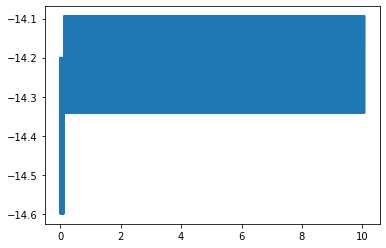

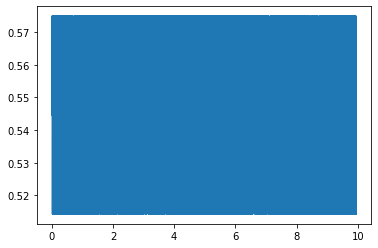

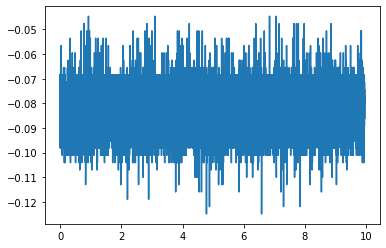

FINISHED MEASUREMENT


In [13]:
# get data - skip on error.

start_time = time.time()
end_time_est = time_of_measurement+start_time
print("the file name: ",file_name+".pickle\n")
print("Started at :", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d,  %H:%M:%S'))    
print("will end at aprox:", datetime.datetime.fromtimestamp(end_time_est).strftime('%Y-%m-%d,  %H:%M:%S'),"\n")    

end_time = 0

while (end_time-start_time < time_of_measurement):
    # first initialise:
    # vars to restart each run.
    data = []
    ch1_data = []
    ch1_time = []
    ch3_data = []
    ch3_time = []
    ch4_data = []
    ch4_time = []
    end_time = time.time()
    # while the loop is still going - try this.
    try:
        # connect to scope:
        rm = visa.ResourceManager()
        usb_list = rm.list_resources()
        scope=rm.get_instrument(usb_port) 
        print(scope.query("*IDN?")) 
        
        # run code for duration of time_of_measurement
        print("scope running: ",scope.write(":RUN")," at ", datetime.datetime.fromtimestamp(time.time()).strftime(' %H:%M:%S') )

        end_time = time.time()
        t_start =  time.time()

        # pause the code for 10 minutes!
        time.sleep(10*60+1)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # get the data.
        print("getting data at ", datetime.datetime.fromtimestamp(time.time()).strftime(' %H:%M:%S'),"\n",scope.write(":STOP"))
        #scope.write(":STOP")
        t_stamp = t_start
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ch1_data = get_data(1)
        ch1_time = time_axis(ch1_data)
        time.sleep(3)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ch3_data = get_data(3)
        ch3_time = time_axis(ch3_data)
        time.sleep(3)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ch4_data = get_data(4)
        ch4_time = time_axis(ch4_data)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
        #save the data to pickle
        str_of_vars = "str_of_vars,description,t_stamp,ch1_data,ch1_time,ch3_data,ch3_time,ch4_data,ch4_time"
        data.append(str_of_vars)
        data.append(description)
        data.append(t_stamp)
        data.append(ch1_data)  
        data.append(ch1_time)
        data.append(ch3_data)  
        data.append(ch3_time)
        data.append(ch4_data)  
        data.append(ch4_time)

        scope.write(":DISPlay:CLEar")
        with open(file_name+'.pickle', 'ab') as handle:
            pickle.dump(data, handle)
        print("saved")
        rm.close()
    except:
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
        #save the data to pickle
        str_of_vars = "str_of_vars,description,t_stamp,ch1_data,ch1_time,ch3_data,ch3_time,ch4_data,ch4_time"
        data.append(str_of_vars)
        data.append(description)
        data.append(t_stamp)
        data.append(ch1_data)  
        data.append(ch1_time)
        data.append(ch3_data)  
        data.append(ch3_time)
        data.append(ch4_data)  
        data.append(ch4_time)

        scope.write(":DISPlay:CLEar")
        with open(file_name+'.pickle', 'ab') as handle:
            pickle.dump(data, handle)
        print("saved, with error.")
        rm.close()
        pass
    
    
plt.plot(ch1_time,ch1_data)
plt.show()
plt.plot(ch3_time,ch3_data)
plt.show()
plt.plot(ch4_time,ch4_data)
plt.show()
print("FINISHED MEASUREMENT")
rm.close()

In [ ]:
print ("stop here.")

In [ ]:
# ### old version of get-data protocol.
# start_time = time.time()
# end_time_est = time_of_measurement+start_time
# print("the file name: ",file_name+".pickle\n")
# print("Started at :", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d,  %H:%M:%S'))    
# print("will end at aprox:", datetime.datetime.fromtimestamp(end_time_est).strftime('%Y-%m-%d,  %H:%M:%S'),"\n")    

# end_time = 0

# while (end_time-start_time < time_of_measurement): 
#     # run code for duration of time_of_measurement
#     print("scope running: ",scope.write(":RUN")," at ", datetime.datetime.fromtimestamp(time.time()).strftime(' %H:%M:%S') )
    
#     # vars to restart each run.
#     data = []
#     ch1_data = []
#     ch1_time = []
#     ch3_data = []
#     ch3_time = []
#     ch4_data = []
#     ch4_time = []
    
#     end_time = time.time()
#     t_start =  time.time()
    
#     # pause the code for 10 minutes!
#     time.sleep(10*60+1)
    
#     # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     # get the data.
#     print("getting data at ", datetime.datetime.fromtimestamp(time.time()).strftime(' %H:%M:%S'),"\n",scope.write(":STOP"))
#     #scope.write(":STOP")
#     t_stamp = t_start
#     # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     ch1_data = get_data(1)
#     ch1_time = time_axis(ch1_data)
#     time.sleep(3)
#     # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     ch3_data = get_data(3)
#     ch3_time = time_axis(ch3_data)
#     time.sleep(3)
#     # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     ch4_data = get_data(4)
#     ch4_time = time_axis(ch4_data)
#     # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
#     #save the data to pickle
#     str_of_vars = "description,str_of_vars,t_stamp,ch1_data,ch1_time,ch3_data,ch3_time,ch4_data,ch4_time"
#     data.append(description)
#     data.append(str_of_vars)
#     data.append(t_stamp)
#     data.append(ch1_data)  
#     data.append(ch1_time)
#     data.append(ch3_data)  
#     data.append(ch3_time)
#     data.append(ch4_data)  
#     data.append(ch4_time)
    
#     scope.write(":DISPlay:CLEar")
#     with open(file_name+'.pickle', 'ab') as handle:
#         pickle.dump(data, handle)
#     print("saved")
    
    
    
# plt.plot(ch1_time,ch1_data)
# plt.show()
# plt.plot(ch3_time,ch3_data)
# plt.show()
# plt.plot(ch4_time,ch4_data)
# plt.show()
# print("FINISHED MEASUREMENT")
# print(scope.write(":RUN"))
# rm.close()

In [26]:
# rm.close()